# 个人睡眠数据分析
这是从我手机App的 Sleep Cycle 中导出的睡眠时间和质量数据，通过Excel做了简单的数据清洗后保存为csv文件，并通过pandas进行进一步的分析
## Step1 检视数据源

1、发现问题 2、总结问题原因 3、解决问题

In [53]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib as plt

In [54]:
df = pd.read_csv("sleepdata.csv")

#### 检视数据源

In [55]:
df.head()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps
0,2016-01-22,00:58:40,2016-01-22,07:28:55,76%,6:30,108.0
1,2016-01-23,00:58:09,2016-01-23,07:30:18,75%,6:32,95.0
2,2016-01-24,01:25:00,2016-01-24,07:30:41,73%,6:05,370.0
3,2016-01-25,01:28:17,2016-01-25,07:32:07,55%,6:03,0.0
4,2016-01-27,01:14:10,2016-01-27,08:10:41,78%,6:56,1110.0


In [56]:
df.tail()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps
226,2016-12-16,02:15:49,2016-12-16,08:58:40,64%,6:42,7307.0
227,2016-12-17,01:12:41,2016-12-17,08:05:34,77%,6:52,8812.0
228,2016-12-18,03:00:00,2016-12-18,10:18:10,78%,7:18,3239.0
229,2016-12-20,01:19:04,2016-12-20,08:18:05,82%,6:59,4855.0
230,2016-12-21,00:28:43,2016-12-21,07:26:09,70%,6:57,6029.0


数据源从2016/1/22-2016/12/21共有230条数据，从左到右的栏依次为睡眠记录开始日期、开始时间、结束日期、结束时间、睡眠质量、床上时间、当天步数

In [57]:
df.dtypes

start_date      object
start_time      object
end_date        object
end_time        object
quality         object
time_in_bed     object
steps          float64
dtype: object

导入的数据中前六列数据都是字符串类型，只有最后一列为float

In [58]:
df.isnull().sum()

start_date     0
start_time     0
end_date       0
end_time       0
quality        0
time_in_bed    0
steps          1
dtype: int64

数据中只有steps一列中存在NULL值

# Step2 数据清洗

#### 睡眠质量数据转换类型

In [59]:
df['quality'] = df['quality'].str.replace('%', '')
df['quality'] = df['quality'].str.replace(';', '')

In [60]:
# df['quality'].str.extract('(\d\d)%') 利用正则表达式

In [61]:
#df['quality'].astype(int) # 为何没有转换成int类型数据？ 产生新的Series而不在原数据上修改

#### 删除quality异常数据

In [62]:
for i in range(df['quality'].shape[0]):
    if int(df['quality'][i]) <= 10:
        df = df.drop(i)

In [63]:
df = df.reset_index(drop=True)

平时的睡眠记录中，经常有测试软件时的数据记录，并非真实的睡眠情况，因此将睡眠质量不大于10%的数据剔除

#### 转换time_in_bed数据格式

In [64]:
time_bed = pd.DataFrame((x.split(':') for x in df['time_in_bed']), columns=['hours','minutes'])
time_bed.head()

,hours,minutes
0,6,30
1,6,32
2,6,05
3,6,03
4,6,56


In [65]:
df['time_in_bed_minute'] = time_bed['minutes']
df['time_in_bed_hour'] = time_bed['hours']

In [66]:
df.tail()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,time_in_bed_minute,time_in_bed_hour
221,2016-12-16,02:15:49,2016-12-16,08:58:40,64,6:42,7307.0,42,6
222,2016-12-17,01:12:41,2016-12-17,08:05:34,77,6:52,8812.0,52,6
223,2016-12-18,03:00:00,2016-12-18,10:18:10,78,7:18,3239.0,18,7
224,2016-12-20,01:19:04,2016-12-20,08:18:05,82,6:59,4855.0,59,6
225,2016-12-21,00:28:43,2016-12-21,07:26:09,70,6:57,6029.0,57,6


In [67]:
df['time_in_bed_minute'] = df['time_in_bed_minute'].astype(int)
df['time_in_bed_hour'] = df['time_in_bed_hour'].astype(int)

In [68]:
df['time_in_bed_minute'] = df['time_in_bed_minute']/60

In [69]:
df['bed_time'] = df['time_in_bed_minute'] + df['time_in_bed_hour']

In [70]:
df['quality'] = df['quality'].astype(int)

In [71]:
df = df.drop('time_in_bed_minute', axis=1)
df = df.drop('time_in_bed_hour', axis=1)

将time_in_bed的时长数据通过分列再组合的方式，转换成float类型的时长数据
将quality数据由object类型转换成int类型数据

In [72]:
df.dtypes

start_date      object
start_time      object
end_date        object
end_time        object
quality          int64
time_in_bed     object
steps          float64
bed_time       float64
dtype: object

In [73]:
df.describe()

,quality,steps,bed_time
count,226.000000,226.000000,226.000000
mean,67.570796,7894.336283,6.610324
std,14.375808,4366.198215,1.104509
min,15.000000,0.000000,1.233333
25%,61.000000,5317.250000,6.333333
50%,70.000000,7440.500000,6.775000
75%,76.000000,9628.000000,7.162500
max,96.000000,25459.000000,8.900000


** 转换Start_time数据格式 **

In [74]:
start_time = pd.DataFrame((x.split(':') for x in df['start_time']), columns=['start_hours','start_minutes','start_seconds'])
start_time.head()

,start_hours,start_minutes,start_seconds
0,00,58,40
1,00,58,09
2,01,25,00
3,01,28,17
4,01,14,10


In [75]:
df['start_minute'] = start_time['start_minutes']
df['start_hour'] = start_time['start_hours']
df['start_second'] = start_time['start_seconds']

In [76]:
df.head()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,bed_time,start_minute,start_hour,start_second
0,2016-01-22,00:58:40,2016-01-22,07:28:55,76,6:30,108.0,6.500000,58,00,40
1,2016-01-23,00:58:09,2016-01-23,07:30:18,75,6:32,95.0,6.533333,58,00,09
2,2016-01-24,01:25:00,2016-01-24,07:30:41,73,6:05,370.0,6.083333,25,01,00
3,2016-01-25,01:28:17,2016-01-25,07:32:07,55,6:03,0.0,6.050000,28,01,17
4,2016-01-27,01:14:10,2016-01-27,08:10:41,78,6:56,1110.0,6.933333,14,01,10


In [77]:
df['start_minute'] = df['start_minute'].astype(int)
df['start_hour'] = df['start_hour'].astype(int)
df['start_second'] = df['start_second'].astype(int)

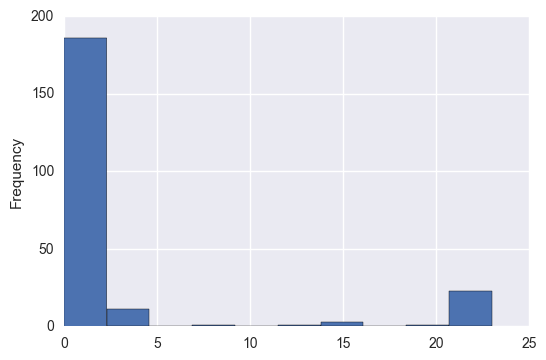

In [104]:
df['start_hour'].plot(kind='hist')

In [105]:
df['start_minute'] = df['start_minute']/60

In [106]:
df['start_num_time'] = df['start_hour'] + df['start_minute']

In [107]:
df.head()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,bed_time,start_minute,start_hour,start_second,start_num_time
0,2016-01-22,00:58:40,2016-01-22,07:28:55,76,6:30,108.0,6.500000,0.966667,0,40,0.966667
1,2016-01-23,00:58:09,2016-01-23,07:30:18,75,6:32,95.0,6.533333,0.966667,0,9,0.966667
2,2016-01-24,01:25:00,2016-01-24,07:30:41,73,6:05,370.0,6.083333,0.416667,1,0,1.416667
3,2016-01-25,01:28:17,2016-01-25,07:32:07,55,6:03,0.0,6.050000,0.466667,1,17,1.466667
4,2016-01-27,01:14:10,2016-01-27,08:10:41,78,6:56,1110.0,6.933333,0.233333,1,10,1.233333


** 删除start_num_time异常的数据 **

In [137]:
# df['start_num_time'].loc(7)

In [143]:
for i in df['start_num_time']:
    if i < 21 and i >6:
        print(i)

** Q: 如何选取入睡时间为7的特定行数据？ **

In [129]:
for i in range(df['start_num_time'].shape[0]):
    if int(df['start_num_time'][i]) < 21 and int(df['start_num_time'][i]) > 6:
        df = df.drop(i)

In [130]:
df = df.reset_index(drop=True)

In [138]:
for i in df['start_num_time']:
    if i < 21 and i >6:
        print(i)

#### 删除bed_time异常数据

In [135]:
for i in range(df['bed_time'].shape[0]):
    if int(df['bed_time'][i]) < 3:
        df = df.drop(i)

In [136]:
df = df.reset_index(drop=True)

同理，将睡眠数据中，睡眠时间小于三小时的特殊记录删除

** 基本数据分析 **

In [149]:
start = []
for i in df['start_num_time']:
    if i <6:
        start.append(i)
    else:
        start.append(i-24)

In [155]:
np.mean(start)

1.0969135802469134

平均入睡时间为凌晨1点5分左右

In [156]:
df['bed_time'].mean()

6.755169753086414

平均睡眠时间为6小时45分钟左右

In [158]:
df['quality'].mean()

68.95833333333333

平均睡眠质量为68.96%

In [159]:
steps = []
for i in df['steps']:
    if i != 0:
        steps.append(i)

In [160]:
np.mean(steps)

7950.68544600939

平均每日步数为7951步

# Step3 数据可视化探索

#### 数据分布

In [40]:
df['steps'].plot()

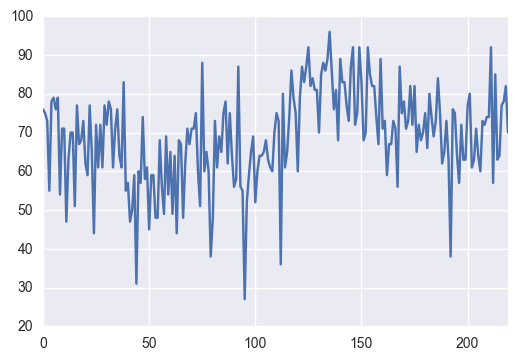

In [226]:
df['quality'].plot()

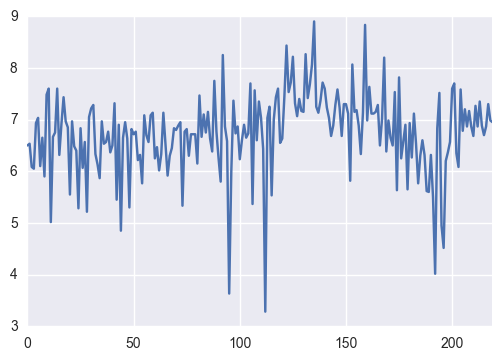

In [227]:
df['bed_time'].plot()

#### 数据之间的联系

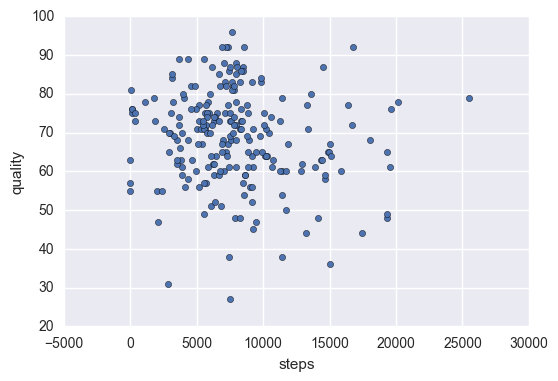

In [229]:
df.plot(kind="scatter", x="steps", y="quality")

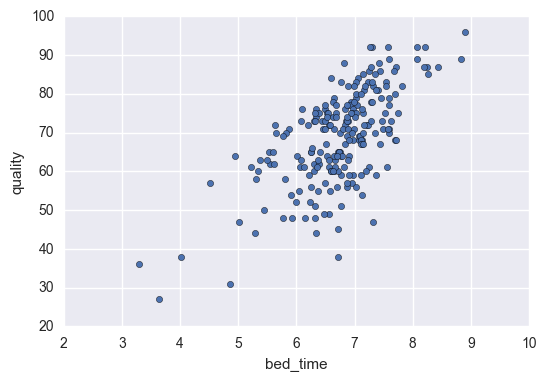

In [230]:
df.plot(kind="scatter", x="bed_time", y="quality")

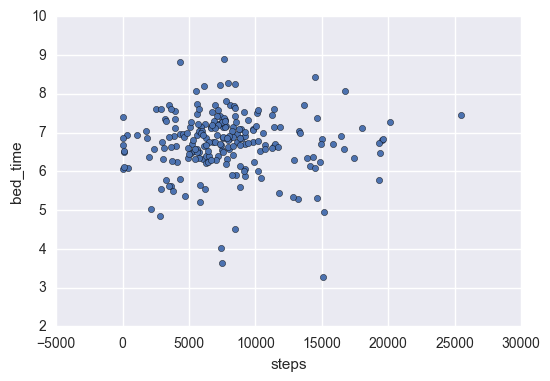

In [231]:
df.plot(kind="scatter", x="steps", y="bed_time")

# 要点
1. 如何实现分列的操作？
2. 如何实现Excel中的Left，Mid等函数操作？用正则表达式？
3. Excel中某些优越性如何通过Python来实现，比如检查表格中的异常数据，如："00;"
4. drop数据后记得要reset_index;
5. pandas的merge操作：要有共同的列？